In [1]:
%matplotlib inline
from vis_common import *
import numpy as np
from matplotlib import pyplot as plt

In [9]:
print "Went from {} games to {} after filtering out games with \
experimental species/bgs, instantly-quit games, and games by bots".format(len(fr), len(f))

Went from 50000 games to 46136 after filtering out games with experimental species/bgs, instantly-quit games, and games by bots


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


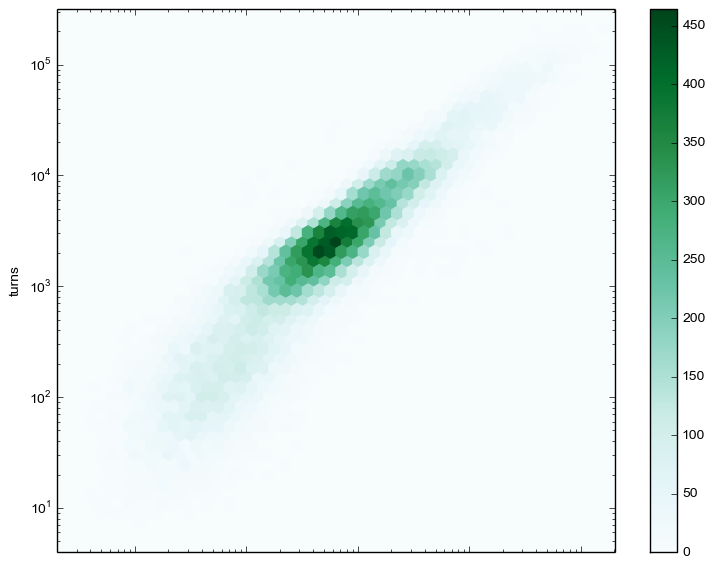

In [3]:
f[ (f['time'] > 0) & (f['turns'] > 0) ].plot.hexbin(x='time', y='turns', 
                                                              gridsize=50, 
                                                    xscale='log', yscale='log',
                                                              figsize=(9,7))

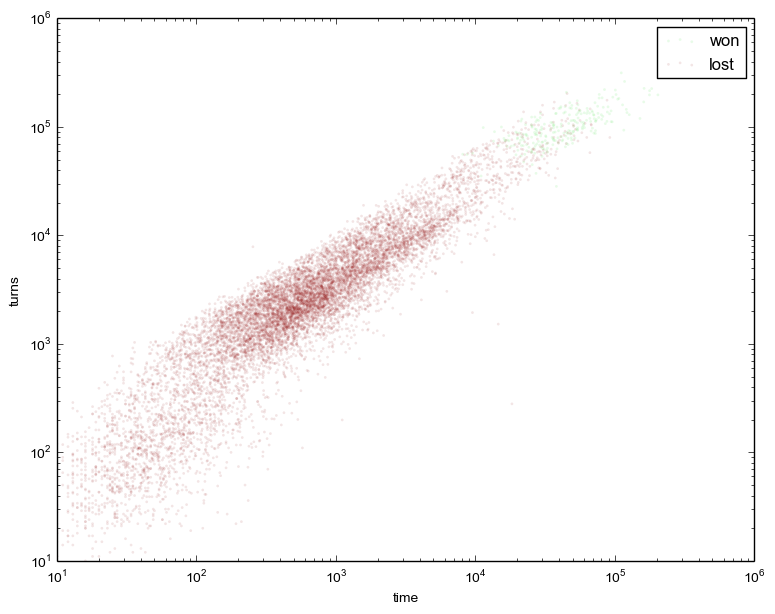

In [4]:
s = 4
alpha = 0.1
ax = f[iwon].head(5000).plot.scatter(x='time', y='turns', color='lightgreen', label='won',
                         #xscale='log', yscale='log',
                                    loglog=1,
                            figsize=(9,7), alpha=alpha*2, s=s, lw=0)
ax.set_xlim(left=10)
ax.set_ylim(bottom=10)
f[ilost].head(10000).plot.scatter(x='time', y='turns', color='darkred', label='lost', ax=ax, alpha=alpha, s=s, lw=0);
# Hey, I found an island of bots!
#f[f['howdied']=='quit'].head(1000).plot.scatter(x='time', y='turns', color='blue', label='quit', ax=ax, alpha=1, s=s, lw=0);

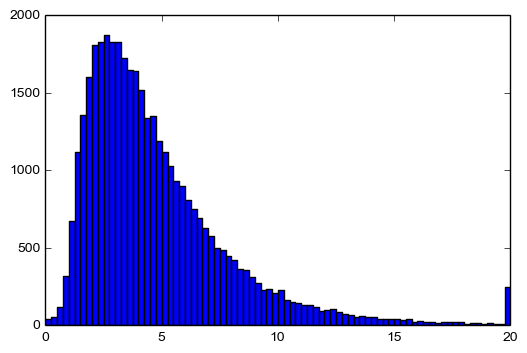

In [5]:
turns_per_sec = (f[f['level'] > 1]['turns'] / f[f['level'] > 1]['time'])
bins = list(np.arange(0, 20, .25)) + [200]
counts, _ = np.histogram(turns_per_sec, bins)
plt.bar(bins[:-1], counts, width=.25);
# Turns taken per second

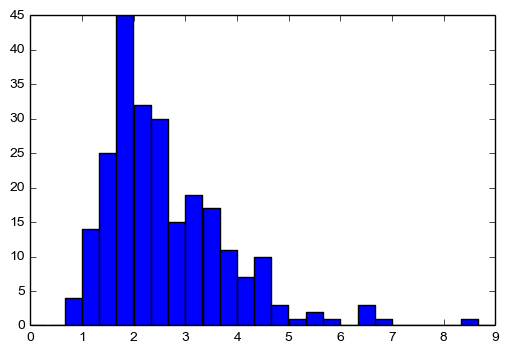

In [6]:
turns_per_sec = (f[iwon]['turns'] / f[iwon]['time'])
bins = list(np.arange(0, 12, 1/3.0)) + [200]
counts, _ = np.histogram(turns_per_sec, bins)
plt.bar(bins[:-1], counts, width=.33);
# Turns per second among winners

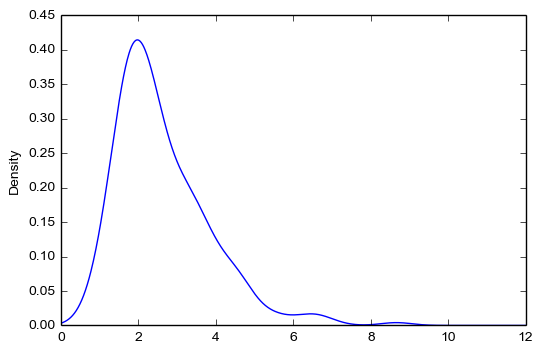

In [7]:
# TODO: I wish there was a way to manually set the bandwidth :(
turns_per_sec.plot.kde(xlim=(0,12))